In [13]:
import os
import os.path
import argparse
import math
import torch
import torchvision.utils as vutils
from datetime import datetime
from einops import rearrange
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from balls import Balls
from dalle_video import DALLE
from utils import *
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()

parser.add_argument('--local_rank', type=int, default=0)
parser.add_argument('--num_workers', type=int, default=4)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--epochs', type=int, default=500)
parser.add_argument('--clip', type=float, default=1.0)
parser.add_argument('--image_size', type=int, default=64)

parser.add_argument('--checkpoint_path', default='/home/t-pbansal/video-dalle/logs/2021-08-15T18:22:55.450448/checkpoint.pt.tar')
parser.add_argument('--data_path', default='/home/t-pbansal/video-dalle/data/bouncing_3balls')

parser.add_argument('--num_dec_blocks', type=int, default=4)
parser.add_argument('--vocab_size', type=int, default=256)
parser.add_argument('--d_model', type=int, default=192)
parser.add_argument('--num_heads', type=int, default=4)
parser.add_argument('--dropout', type=float, default=0.1)

# parser.add_argument('--num_iterations', type=int, default=7)
parser.add_argument('--num_iterations', type=int, default=5)
parser.add_argument('--num_slots', type=int, default=4)
# parser.add_argument('--num_slots', type=int, default=8)
parser.add_argument('--cnn_hidden_size', type=int, default=32)
parser.add_argument('--slot_size', type=int, default=64)
# parser.add_argument('--slot_size', type=int, default=32)
parser.add_argument('--mlp_hidden_size', type=int, default=128)
parser.add_argument('--img_channels', type=int, default=3)
parser.add_argument('--pos_channels', type=int, default=4)
parser.add_argument('--sample_length', type=int, default=20)
parser.add_argument('--num_gt_steps', type=int, default=10)
parser.add_argument('--num_generation_steps', type=int, default=10)
parser.add_argument('--num_vis', type=int, default=8)

parser.add_argument('--tau_start', type=float, default=1.0)
parser.add_argument('--tau_final', type=float, default=0.1)
parser.add_argument('--tau_epochs', type=int, default=3)

parser.add_argument('--hard', action='store_true')
parser.add_argument('--sample_batch', action='store_true')

parser.add_argument('--memory_type', type=str, choices=['slots', 'conv', 'vector'], default='slots')

parser.add_argument('--fast_run', action='store_true', default=False)

parser.add_argument('-f','--file')
args = parser.parse_args()

torch.manual_seed(args.seed)

val_dataset = Balls(root=args.data_path, mode='val')

loader_kwargs = {
    'batch_size': args.batch_size,
    'shuffle': False,
    'num_workers': args.num_workers,
    'pin_memory': True,
    'drop_last': True,
}

val_loader = DataLoader(val_dataset,  **loader_kwargs)

model = DALLE(args)

print(f'Loading from checkpoint {args.checkpoint_path}')
checkpoint = torch.load(args.checkpoint_path, map_location='cpu')
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['best_val_loss']
best_epoch = checkpoint['best_epoch']
model.load_state_dict(checkpoint['model'])

model = model.cuda()

def visualize(video, recon, recon_transformer=None, N=8):
    B, T, C, H, W = video.shape
    video = video[:N].unsqueeze(1)
    recon = recon[:N].unsqueeze(1)
    recon_diff = video - recon
    vis_list = [video, recon, recon_diff]
    if recon_transformer is not None:
        recon_transformer = recon_transformer[:N].unsqueeze(1)
        recon_transformer_diff = video - recon_transformer
        vis_list.extend([recon_transformer, recon_transformer_diff])
    vis = torch.cat(vis_list, dim=1).view(-1, C, H, W)
    return vis

def visualize_attn(video, attn, N=2):
    # [[predicted frame, attended frame 1, slot1, slot2, etc...],
    #  [predicted frame, attended frame 2, slot1, slot2, etc...]
    #  ...]
    B, T, C, H, W = video.shape
    predicted = video[:N,:][:, :, None, ...]
    attn = attn[:N]
    #attn = attn * attended
    # attn = attn * predicted + 1 - attn
    # attn = 1-attn(1-predicted)
    vis = torch.cat([predicted, predicted, attn], dim=-4)
    vis = vis.view(-1, C, H, W)
    return vis

def visualize_gen(video, recon, N=8):
    _, _, H, W = image.shape
    image = image[:N].expand(-1, 3, H, W).unsqueeze(dim=1)
    recon = recon[:N].expand(-1, 3, H, W).unsqueeze(dim=1)

    return torch.cat((image, recon), dim=1).view(-1, 3, H, W)

with torch.no_grad():
    for val_batch, full_video in enumerate(val_loader):
        full_video = full_video.cuda(non_blocking=True)
        video = full_video[:, :args.sample_length]
        break
        recon_transformer = model.generate(video)
        gen_vis = visualize(video[:,-recon_transformer.shape[1]:], recon_transformer, N=args.num_vis)
        gen_vis_grid = vutils.make_grid(gen_vis, nrow=recon_transformer.shape[1], pad_value=1)
    #     plt.imshow(gen_vis_grid)
        break

Loading from checkpoint /home/t-pbansal/video-dalle/logs/2021-08-15T18:22:55.450448/checkpoint.pt.tar


In [40]:
seen_sofar = video[:,:3].clone()
seen_sofar[:,:,0] += seen_sofar[:,:,1]
seen_sofar[:,:,1] =0

for _ in range(17):
    recon_transformer = model.generate(torch.cat([seen_sofar[:,-3:],torch.zeros_like(seen_sofar[:,:1])],dim=1))
    seen_sofar = torch.cat([seen_sofar,recon_transformer.detach().clone()],dim=1)
# # gen_vis = visualize(video[:,:13], seen_sofar, N=args.num_vis)
# # gen_vis_grid = vutils.make_grid(gen_vis, nrow=13, pad_value=1)


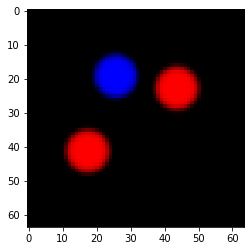

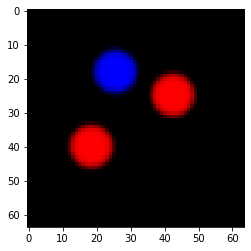

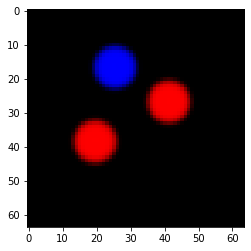

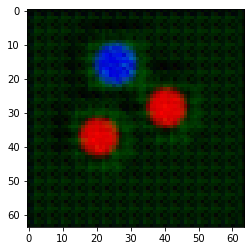

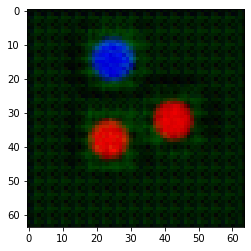

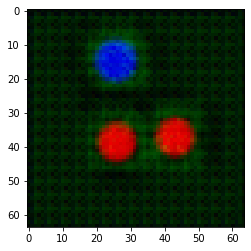

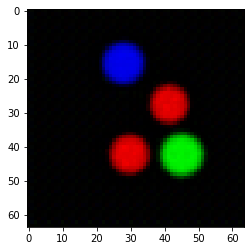

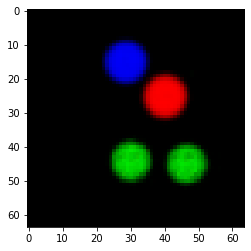

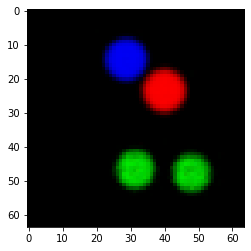

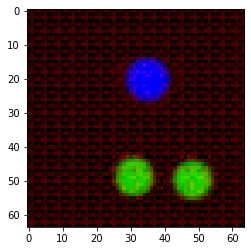

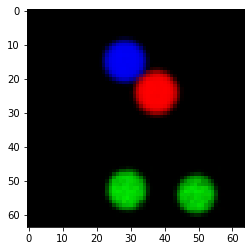

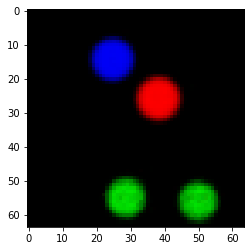

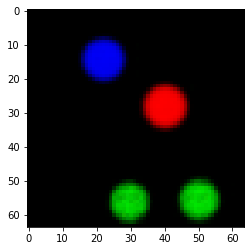

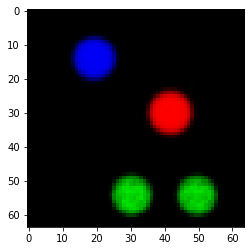

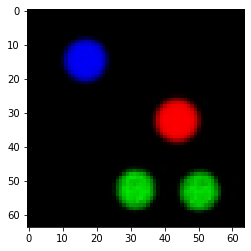

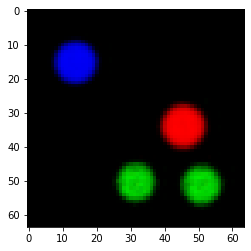

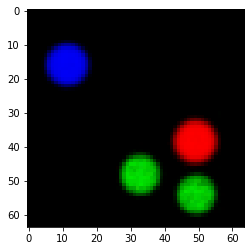

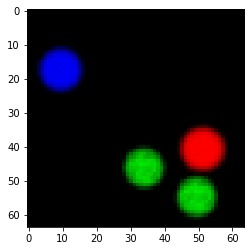

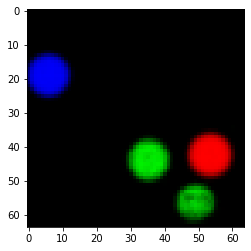

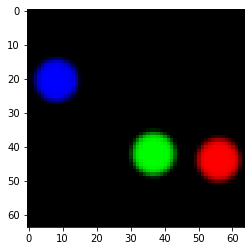

In [42]:
sample=0
for i in range(20):
    plt.imshow(seen_sofar[sample].detach().cpu().numpy().transpose(0,2,3,1)[i])
    plt.show()

In [4]:
# seen_sofar = video[:,:3].clone()
# for i in range(17):
#     if (i == ):
#     recon_transformer = model.generate(torch.cat([seen_sofar[:,-3:],torch.zeros_like(seen_sofar[:,:1])],dim=1))
#     seen_sofar = torch.cat([seen_sofar,recon_transformer.detach().clone()],dim=1)




In [12]:

import os
import imageio

# images = []
# images.append()
sample=5
imageio.mimsave('generated_experiment.gif', recon_transformer[sample].detach().cpu().numpy().transpose(0,2,3,1))
imageio.mimsave('original_experiment.gif', seen_sofar[sample].detach().cpu().numpy().transpose(0,2,3,1))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [8]:
print (video.shape,seen_sofar.shape)

torch.Size([8, 20, 3, 64, 64]) torch.Size([8, 20, 3, 64, 64])


In [41]:
# from array2gif import write_gif
# write_gif(seen_sofar[sample].detach().cpu().numpy().transpose(0,2,3,1), 'generated.gif', fps=4)

import os
import imageio

# images = []
# images.append()
sample=0
imageio.mimsave('generated_latest12.gif', seen_sofar[sample].detach().cpu().numpy().transpose(0,2,3,1))
imageio.mimsave('original_latest12.gif', video[sample].detach().cpu().numpy().transpose(0,2,3,1))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Time Step : 0
torch.Size([13, 3, 64, 64]) torch.Size([13, 3, 64, 64])


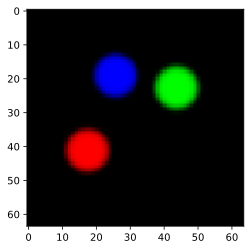

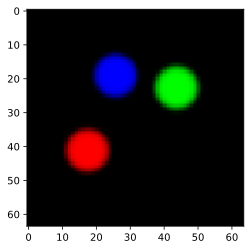

In [49]:
sample = 0
# video_ = video[sample,-recon_transformer.shape[1]:]
# recon_ = recon_transformer[sample,-recon_transformer.shape[1]:]
video_ = video[sample,:13]
recon_ = seen_sofar[sample]
for i in range(1):
    print ("Time Step : %d"%i)
    print (video_.shape,recon_.shape)
    plt.imshow(video_[i].detach().cpu().numpy().transpose(1,2,0))
    plt.show()
    plt.imshow(recon_[i].detach().cpu().numpy().transpose(1,2,0))
    plt.show()
    

In [19]:
image = video[:,:3].clone()
gen_len = (image.size(-1) // 4) ** 2

B,T, C, H, W = image.size()

# dvae encode
z_logits = F.log_softmax(model.dvae.encoder(image.flatten(end_dim=1)), dim=1)  # batch_size x vocab_size x 4 x 4
_, _, H_enc, W_enc = z_logits.size()

# hard z
z_hard = torch.argmax(z_logits, axis=1)
z_hard = F.one_hot(z_hard, num_classes=model.vocab_size).permute(0, 3, 1, 2).float()  # batch_size x vocab_size x 4 x 4

# target for transformer
one_hot_tokens = z_hard.permute(0, 2, 3, 1).flatten(start_dim=1, end_dim=2)  # batch_size x 16 x vocab_size

# inputs for transformer with bos
token_embeddings = torch.cat([torch.zeros_like(one_hot_tokens[..., :1]), one_hot_tokens], dim=-1)  # batch_size x 16 x 1+vocab_size
token_embeddings = torch.cat([torch.zeros_like(token_embeddings[..., :1, :]), token_embeddings], dim=-2)  # batch_size x 1+16 x 1+vocab_size
token_embeddings[:, 0, 0] = 1.0  # set bos # batch_size x 1+16 x vocab_size+1
token_embeddings = model.dictionary(token_embeddings)  # batch_size x 16 x d_model
token_embeddings = model.positional_encoder(token_embeddings)

z_transformer_input = z_hard.new_zeros(B*(T-model.warmup), 1, model.vocab_size + 1)
z_transformer_input[..., 0] = 1.0  # batch_size x 1 x vocab_size+1

# slot attention
slots, attns = model.slot_attn(token_embeddings[:, 1:])
attns = attns.transpose(-1, -2)
attns = attns.reshape(B*T, model.num_slots, 1, H_enc, W_enc).repeat_interleave(H // H_enc, dim=-2).repeat_interleave(W // W_enc, dim=-1)
# `attns` has shape: [batch_size, num_slots, 1, enc_height, enc_width].
# attns = image.unsqueeze(1) * attns
attns = image.flatten(end_dim=1).unsqueeze(1) * attns + 1. - attns

In [32]:
for i in range(1):
    print (slots[i]@slots[i+1].T)

tensor([[-0.5208,  6.7857, 17.8511,  7.2691],
        [ 5.1377, -4.0834,  5.5893, 22.6458],
        [ 1.0432, 19.5843,  7.3351, -3.1963],
        [20.0423,  1.9806, -0.6930,  6.7730]], device='cuda:0',
       grad_fn=<MmBackward>)


tensor(20.0423, device='cuda:0', grad_fn=<SumBackward0>)


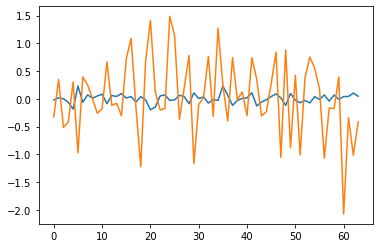

In [39]:
print((slots[0,3]*slots[1,0]).sum())
plt.plot((slots[0,3]-slots[1,0]).detach().cpu().numpy())
plt.plot((slots[0,3]-slots[1,3]).detach().cpu().numpy())

In [28]:
attns[0,0].detach().cpu().numpy().shape

(3, 64, 64)

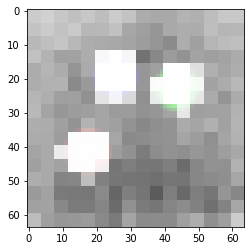

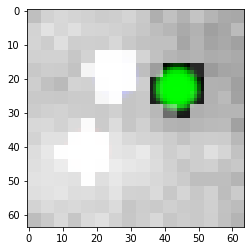

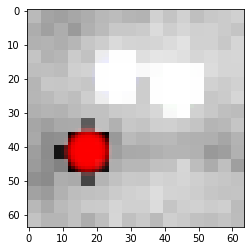

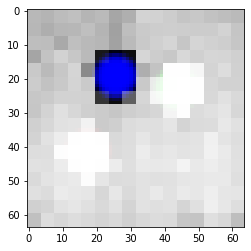

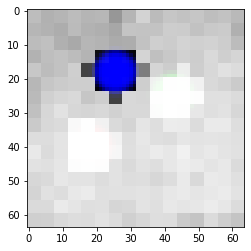

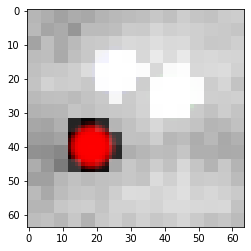

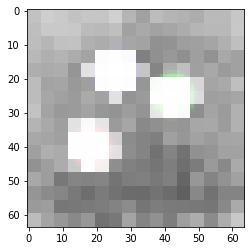

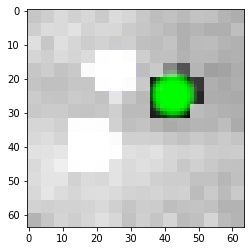

In [33]:
plt.imshow(attns[0,0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[0,1].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[0,2].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[0,3].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[1,0].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[1,1].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[1,2].detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(attns[1,3].detach().cpu().numpy().transpose(1,2,0))
plt.show()
